In [1]:
import torch,torchvision,os,pyhessian,time
import torchvision.transforms as transforms
import numpy as np
import pyhessian
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import os
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True).cuda()

Using cache found in /home/zihao/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [2]:
train,test = get_loader('cifar10'.upper(),batch_size=256,test_batch_size=256)
train.num_workers = 4
test.num_workers = 4
train.pin_in_memory = True
test.pin_in_memory = True

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torchvision.models as models                           # for example model
from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.convert_deploy import convert_deploy             # remove quant nodes for deploy
from mqbench.advanced_ptq import ptq_reconstruction

from copy import deepcopy
model.eval()
mqb_model = deepcopy(model)
torch_fp_model = deepcopy(model)
torch_quantized_model = deepcopy(model)
torch_perturb_model = deepcopy(model)
model = None

In [4]:
# MSE calibration on model parameters
backend = BackendType.Academic
extra_config = {
    'extra_qconfig_dict': {
        'w_observer': 'MSEObserver',                              # custom weight observer
        'a_observer': 'EMAMSEObserver',                              # custom activation observer
        'w_fakequantize': 'FixedFakeQuantize',                    # custom weight fake quantize function
        'a_fakequantize': 'FixedFakeQuantize',                    # custom activation fake quantize function
        'w_qscheme': {
            'bit': 4,                                             # custom bitwidth for weight,
            'symmetry': True,                                    # custom whether quant is symmetric for weight,
            'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
            'pot_scale': False,                                   # custom whether scale is power of two for weight.
        },
        'a_qscheme': {
            'bit': 8,                                             # custom bitwidth for activation,
            'symmetry': False,                                    # custom whether quant is symmetric for activation,
            'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
            'pot_scale': False,                                   # custom whether scale is power of two for activation.
        }
    }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
}

In [5]:
mqb_model = prepare_by_platform(mqb_model, backend,extra_config).cuda()

[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 4 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
[MQBENCH] INFO: Set x post act quantize to 8 bit.
[MQBENCH] INFO: Insert act quant x_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_1_relu_post_act_fake_quanti

In [6]:
# calibration loop
enable_calibration(mqb_model)
for i, batch in enumerate(train):
    
    mqb_model(batch[0].cuda())
    
    if i == 3: break # use the first 4 batches (1024 samples) to do calibration   

[MQBENCH] INFO: Enable observer and Disable quantize.


In [7]:
# evaluation loop
from mqbench.utils.state import disable_all
enable_quantization(mqb_model)
# disable_all(mqb_model)
evaluate(test,mqb_model)

[MQBENCH] INFO: Disable observer and Enable quantize.


{'mean_acc': 0.8833,
 'qtl_acc': 0.8833,
 'mean_loss': 0.43942759484052657,
 'qtl_loss': 0.43942759484052657,
 'test time': 0.8666608333587646,
 'acc_list': array([0.8833]),
 'loss_list': array([0.43942759])}

In [8]:
def getModuleByName(modelName,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    eval_str = modelName
    for token in tokens:
        try:
            eval_str += f'[{int(token)}]'
        except:
            eval_str += f'.{token}'
            
    return eval(eval_str)
    
for n,m in mqb_model.named_modules():
    if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
        print('loading quantized weight for layer',n)
        torch_module = getModuleByName('torch_quantized_model',n)
        torch_module.weight.data = m.weight_fake_quant(m.weight).data

loading quantized weight for layer conv1
loading quantized weight for layer fc
loading quantized weight for layer layer1.0.conv1
loading quantized weight for layer layer1.0.conv2
loading quantized weight for layer layer1.1.conv1
loading quantized weight for layer layer1.1.conv2
loading quantized weight for layer layer1.2.conv1
loading quantized weight for layer layer1.2.conv2
loading quantized weight for layer layer2.0.conv1
loading quantized weight for layer layer2.0.conv2
loading quantized weight for layer layer2.0.downsample.0
loading quantized weight for layer layer2.1.conv1
loading quantized weight for layer layer2.1.conv2
loading quantized weight for layer layer2.2.conv1
loading quantized weight for layer layer2.2.conv2
loading quantized weight for layer layer3.0.conv1
loading quantized weight for layer layer3.0.conv2
loading quantized weight for layer layer3.0.downsample.0
loading quantized weight for layer layer3.1.conv1
loading quantized weight for layer layer3.1.conv2
loading

In [9]:
evaluate(test,torch_perturb_model) 

{'mean_acc': 0.926,
 'qtl_acc': 0.926,
 'mean_loss': 0.28646136410534384,
 'qtl_loss': 0.28646136410534384,
 'test time': 0.6562838554382324,
 'acc_list': array([0.926]),
 'loss_list': array([0.28646136])}

In [10]:
mqb_model = None

## FeintLady

In [11]:
from collections import OrderedDict
# 1. record all modules we want to consider
layers_to_quant = OrderedDict() # layer_name:[torch_fp_module,torch_q_module,torch_p_module]
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

for n,m in torch_fp_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n] = [m,]
        
for n,m in torch_quantized_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n].append(m)

for n,m in torch_perturb_model.named_modules():
    if isinstance(m,types_to_quant):
        layers_to_quant[n].append(m)

In [12]:
res = evaluate(test,torch_perturb_model)
ref_metric = ('mean_loss',res['mean_loss'])

In [13]:
def perturb_loss(perturb_names,ref_metric):
    with torch.no_grad():
        # perturb layers
        for n in perturb_names:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][1].weight.data
        # do evaluation
        res = evaluate(test,torch_perturb_model)
        perturbed_loss = res[ref_metric[0]] - ref_metric[1]
#         print(res)
        # recover layers
        for n in perturb_names:
            layers_to_quant[n][2].weight.data = layers_to_quant[n][0].weight.data
    return perturbed_loss

In [14]:
import time
s_time = time.time()
cached = {}
for n in layers_to_quant:
    for m in layers_to_quant:
        if n == m:
            print('perturb layer',n)
            p = perturb_loss([n,],ref_metric)
            cached[(n,n)] = p
        if (n,m) not in cached:
            print('perturb layer',n,m)
            p = perturb_loss([n,m],ref_metric)
            cached[(n,m)] = p
            cached[(m,n)] = p   
print(f'{time.time()-s_time:.2f} seconds elapsed')

perturb layer conv1
perturb layer conv1 layer1.0.conv1
perturb layer conv1 layer1.0.conv2
perturb layer conv1 layer1.1.conv1
perturb layer conv1 layer1.1.conv2
perturb layer conv1 layer1.2.conv1
perturb layer conv1 layer1.2.conv2
perturb layer conv1 layer2.0.conv1
perturb layer conv1 layer2.0.conv2
perturb layer conv1 layer2.0.downsample.0
perturb layer conv1 layer2.1.conv1
perturb layer conv1 layer2.1.conv2
perturb layer conv1 layer2.2.conv1
perturb layer conv1 layer2.2.conv2
perturb layer conv1 layer3.0.conv1
perturb layer conv1 layer3.0.conv2
perturb layer conv1 layer3.0.downsample.0
perturb layer conv1 layer3.1.conv1
perturb layer conv1 layer3.1.conv2
perturb layer conv1 layer3.2.conv1
perturb layer conv1 layer3.2.conv2
perturb layer conv1 fc
perturb layer layer1.0.conv1
perturb layer layer1.0.conv1 layer1.0.conv2
perturb layer layer1.0.conv1 layer1.1.conv1
perturb layer layer1.0.conv1 layer1.1.conv2
perturb layer layer1.0.conv1 layer1.2.conv1
perturb layer layer1.0.conv1 layer1.2.

perturb layer layer2.1.conv2 layer3.1.conv1
perturb layer layer2.1.conv2 layer3.1.conv2
perturb layer layer2.1.conv2 layer3.2.conv1
perturb layer layer2.1.conv2 layer3.2.conv2
perturb layer layer2.1.conv2 fc
perturb layer layer2.2.conv1
perturb layer layer2.2.conv1 layer2.2.conv2
perturb layer layer2.2.conv1 layer3.0.conv1
perturb layer layer2.2.conv1 layer3.0.conv2
perturb layer layer2.2.conv1 layer3.0.downsample.0
perturb layer layer2.2.conv1 layer3.1.conv1
perturb layer layer2.2.conv1 layer3.1.conv2
perturb layer layer2.2.conv1 layer3.2.conv1
perturb layer layer2.2.conv1 layer3.2.conv2
perturb layer layer2.2.conv1 fc
perturb layer layer2.2.conv2
perturb layer layer2.2.conv2 layer3.0.conv1
perturb layer layer2.2.conv2 layer3.0.conv2
perturb layer layer2.2.conv2 layer3.0.downsample.0
perturb layer layer2.2.conv2 layer3.1.conv1
perturb layer layer2.2.conv2 layer3.1.conv2
perturb layer layer2.2.conv2 layer3.2.conv1
perturb layer layer2.2.conv2 layer3.2.conv2
perturb layer layer2.2.conv2

In [15]:
layer_index = {}
cnt = 0
for layer in layers_to_quant:
    layer_index[layer] = cnt
    cnt += 1
L = cnt

In [16]:
import numpy as np
hm = np.zeros(shape=(L,L))
for n in layers_to_quant:
    for m in layers_to_quant:
        hm[layer_index[n],layer_index[m]] = cached[(n,m)]

In [17]:
cached_grad = np.zeros_like(hm)

In [18]:
for i in range(L):
    for j in range(L):
        if i == j:
            cached_grad[i,j] = 0.5 * hm[i,j]
        else:
            cached_grad[i,j] = 0.5 * (hm[i,j] - hm[i,i] - hm[j,j])

In [19]:
cached_grad

array([[ 4.16934490e-05,  1.09550357e-04,  8.70123506e-05,
         3.60045582e-05,  2.94178724e-05,  5.62150031e-05,
         1.14321709e-05,  5.31995669e-05,  1.00730173e-04,
        -1.15052424e-04, -5.61973080e-05, -2.28986144e-05,
        -4.89939004e-05, -7.98352063e-05, -1.83467939e-04,
        -8.35511833e-05, -1.54895708e-05, -5.28531149e-05,
        -3.75006348e-06,  9.78056341e-06, -1.59651041e-05,
        -6.42966479e-06],
       [ 1.09550357e-04,  4.24776003e-03,  2.11605299e-03,
         8.57040286e-05,  2.76977569e-04,  1.22486930e-03,
         6.45171106e-04,  6.93453476e-05,  9.52508673e-04,
        -1.23043340e-03, -3.70357744e-04, -1.61342323e-06,
        -1.03405975e-03,  8.21219757e-05, -8.22045840e-04,
        -5.20916656e-04, -3.37938778e-04,  1.64996982e-03,
         5.48519194e-04,  4.76930290e-06, -1.64005905e-06,
        -2.71238387e-06],
       [ 8.70123506e-05,  2.11605299e-03,  5.51590435e-03,
         1.45617537e-03,  1.94935873e-04,  1.03757270e-03,
    

In [20]:
X = cached_grad
X[X<0] = 0
X_std = (X - X.min()) / (X.max() - X.min())

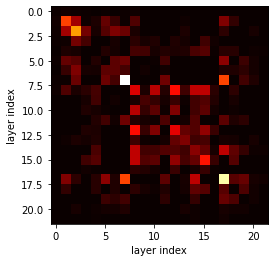

In [21]:
plt.imshow(X_std,cmap='hot')
plt.xlabel('layer index')
plt.ylabel('layer index')
plt.savefig('resnet20_feintgrad.pdf',transparent=True, bbox_inches='tight', pad_inches=0)

In [22]:
import pickle
with open('feintlady_resnet20','wb') as f:
    pickle.dump({'Ltilde':hm,'layer_index':layer_index},f)